# Multivariate GCD benchmarks



## Methods

Performance of GCD was evaluated on both random and non-random polynomial inputs.

Each GCD problem with random polynomials was prepared in the following way. Given the polynomial ring $R[x_1, \dots, x_N]$ and size $S$ (that is the number of monomial terms), the GCD triplet of three random polynomials $a$, $b$ and $g$ each with the given size $S$ was generated. Then the GCDs of $(a*g, b*g)$ (non-trivial result proportional to $g$) and $(a*g + 1, b*g)$ (trivial result) were computed.

Random exponent vectors of each monomial in random poly were generated according to one of the following distributions:

### Uniform exponents distribution

Provided two values $D_{\text{min}}$ and $D_{\text{max}}$, exponent of each variable in the monomial is chosen independendly and uniformly with $D_{\text{min}} \leq exp < D_{\text{max}}$. Obviously, such method gives exponents independently and uniformly distributed between variables in each monomial with the total monomial degree in the range $N D_{\text{min}} \leq Deg < N D_{\text{max}}$: ![Uniform distribution](uniform.png "uniform distribution")

### Sharp exponents distribution

Provided a single value $D_{\text{sum}}$, exponents are chosen according to some multinomial distribution so that the total degree is $D_{\text{sum}}$. In particular, the exponent of some variable (picked at random) is chosen uniformly so that $0 \leq exp_1 \leq D_{\text{sum}}$, then the exponent of some next variable is chosen uniformly so that $0 \leq exp_2 \leq (D_{\text{sum}} - exp_1)$ and so on. Obviously, this method gives quite "sharp" distribution of exponents inside the monomials: ![Sharp distribution](sharp.png "uniform distribution")


## Input problems

The following sets of input problems were generated:

 - __Performance dependence on number of variables__:
 
     - GCD triplets ($a$, $b$, $g$) with size of each polynomial equal to 40 were used
     - for _uniform_ exponents distribution $D_{\text{min}} = 0$ and $D_{\text{max}} = 30$ were used
     - for _sharp_ exponents distribution $D_{\text{sum}} = 50$ was used
     - problems over $Z$ and over $Z_2$ were considered
     - for polynomials over $Z$ random 32-bit integer coefficints were used

 - __Performance dependence on input size__

     - GCD triplets ($a$, $b$, $g$) in $Z[x_1, x_2, x_3]$ and $Z[x_1, x_2, x_3, x_4]$ with size of each polynomial varying from 50 to 5000 were used
     - only _sharp_ distribution with $D_{\text{sum}} = 50$ was used
     - 256-bit random integer coefficients were used
     

Input was generated and analyzed with [algebench](https://github.com/PoslavskySV/algebench). See [README.md](../README.md) for defails.


## Software

The following software were tested:

 * Rings v2.3.2 (http://github.com/PoslavskySV/rings)
 * Wolfram Mathematica v11.1.1.0 (http://wolfram.com/mathematica)
 * Singular v4.1.0 (https://www.singular.uni-kl.de)
 * FORM v4.2.0 (https://www.nikhef.nl/~form/)
 * Fermat v6.19 (http://home.bway.net/lewis/)
 
All tests below were executed on MacBook Pro (15-inch, 2017), 3,1 GHz Intel Core i7, 16 GB 2133 MHz LPDDR3.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os.path

from matplotlib import rcParams
rcParams['font.size'] = 12
rcParams['font.weight'] = 'normal'

In [2]:
AllTools = ['Rings', 'Mathematica', 'FORM', 'Fermat', 'Singular']
ResultsPath = '../results/'

def get_results_file(name):
    return "%s%s"%(ResultsPath, name)

## Performance dependence on number of variables

In [3]:
# the total time statistics
statistics = None

for char in [0, 2]:
    for dist in ['uniform', 'sharp']:
        for nvars in range(3, 9):
            fname = get_results_file('gcd_%s_nvars_%s_characteristic_%s.results.tsv'%(dist, nvars, char))
            if not os.path.isfile(fname):
                continue
                
            df = pd.read_csv(fname, sep='\t', header=0)
            df['dist'] = dist
            df['char'] = char
            df['nvars'] = nvars

            if statistics is None:
                statistics = df
            else:
                statistics = pd.concat([statistics, df], verify_integrity=True, ignore_index=True)
            
summary_statistics = statistics[['nvars', 'dist', 'char'] + AllTools] \
                        .groupby(['nvars', 'dist', 'char']) \
                        .agg(['median', 'min', 'max'])
summary_statistics.columns = [' '.join(col).strip() for col in summary_statistics.columns.values]
summary_statistics = summary_statistics.reset_index()

In [4]:
# https://stackoverflow.com/a/35501485/946635
def linewidth_from_data_units(linewidth, axis, reference='y'):
    """
    Convert a linewidth in data units to linewidth in points.

    Parameters
    ----------
    linewidth: float
        Linewidth in data units of the respective reference-axis
    axis: matplotlib axis
        The axis which is used to extract the relevant transformation
        data (data limits and size must not change afterwards)
    reference: string
        The axis that is taken as a reference for the data width.
        Possible values: 'x' and 'y'. Defaults to 'y'.

    Returns
    -------
    linewidth: float
        Linewidth in points
    """
    fig = axis.get_figure()
    if reference == 'x':
        length = fig.bbox_inches.width * axis.get_position().width
        value_range = np.diff(axis.get_xlim())
    elif reference == 'y':
        length = fig.bbox_inches.height * axis.get_position().height
        value_range = np.diff(axis.get_ylim())
    # Convert length to points
    length *= 72
    # Scale linewidth to value range
    # convert to Python's built-in float required for pyplot
    return float(linewidth * (length / value_range))

In [5]:
style_colors = {
    'Rings'       : '#377eb8', 
    'Mathematica' : '#e41a1c', 
    'FORM'        : '#4daf4a', 
    'Fermat'      : '#ff7f00', 
    'Singular'    : '#984ea3'
}

In [6]:
def plot_nvars_dep(dist, char = 0, ax = None, show_legend = True, show_x_ticks = True):
    all_tools = AllTools if char == 0 else ['Rings', 'Singular']

    if ax is None:
        plt.figure(figsize=(2 * 5, 2 * 2)) 
        ax = plt.gca()

    df = summary_statistics[(summary_statistics.dist == dist) & (summary_statistics.char == char)]

    # from nanoseconds to seconds
    nanos   = 1e-9
    # timeout (8 hours)
    timeout = 60 * 60 * 8

    ymin = 1e-2
    timeout 
    ymax = 5e5
    xmin = 2
    xmax = 9

    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.set_yscale('log')

    # width of bar
    bar_width = 0.1
    bar_width_px = linewidth_from_data_units(bar_width, ax, reference = 'x')
    # sep between bars
    bar_sep = 0.01
    # available nvars
    xarray = sorted(statistics.nvars.unique())

    nvars_available = range(3, 9)
    for nvars in nvars_available:
        df_spec = df[df.nvars == nvars]
        #tools_done = [t for t in all_tools if len(df_spec[t + " median"].dropna()) != 0]
        
        mids = float(len(all_tools) - 1) / 2
        i_tool = 0
        for tool in all_tools[::-1]:
            xdelta = -(bar_sep + bar_width) * (i_tool - mids)
            med_val = df_spec[tool + " median"].iloc[0] * nanos
            min_val = df_spec[tool + " min"].iloc[0]    * nanos
            max_val = df_spec[tool + " max"].iloc[0]    * nanos

            if np.isnan(med_val):
                med_val = timeout
                min_val = timeout
                max_val = timeout
            
            # the second event canceled with timeout
            if len(statistics[(statistics.nvars == nvars) 
                              & (statistics.dist == dist)][tool].dropna()) == 1:
                max_val = timeout
                
            ## plot bar
            ax.plot(
                [nvars + xdelta, nvars + xdelta], [ymin, med_val],
                linestyle='-',
                lw = bar_width_px, 
                c = style_colors[tool], 
                alpha = 0.3)


            # plot error bar
            (_, caps, _) = ax.errorbar(
                [nvars + xdelta], [med_val],
                yerr=[[med_val - min_val], [max_val - med_val]], 
                linestyle='None', 
                lw = bar_width_px / 4,
                marker='o', 
                c = style_colors[tool])
            for cap in caps:
                cap.set_markeredgewidth(bar_width_px /4)
           
            i_tool += 1
    
    ax.plot([0, xmax], [timeout, timeout], linestyle = '--', c  ='grey')
    ax.text(2.5, 1.1 * timeout, 'timeout = 8 hours')
    
    if show_x_ticks:
        ax.set_xticks(nvars_available)
        ax.set_xticklabels(['#vars = %s'%i for i in nvars_available])
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])
        
    ax.tick_params(axis=u'x', which=u'both', length=0)
    
    #legend
    ax.set_ylabel('time per problem, s')
    if show_legend:
        for tool in AllTools:
            ax.plot([], [], c = style_colors[tool], lw = bar_width_px, label = tool, alpha=0.6)
        ax.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.3), ncol=5, frameon = False, fontsize=11)

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


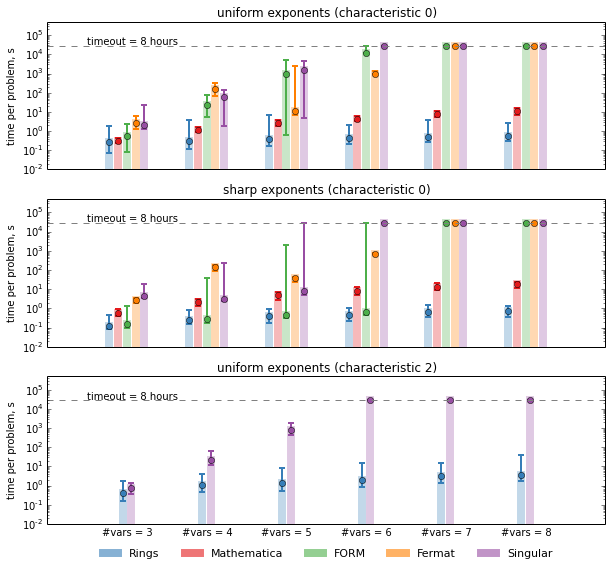

In [7]:
f, (ax_uniform, ax_sharp, ax_char2) = plt.subplots(3, sharex=True, figsize=(2 * 5, 3 * 3))

plot_nvars_dep('uniform', ax = ax_uniform, show_legend=False, show_x_ticks=False)
ax_uniform.set_title('uniform exponents (characteristic 0)')

plot_nvars_dep('sharp', ax = ax_sharp, show_legend=False, show_x_ticks=False)
ax_sharp.set_title('sharp exponents (characteristic 0)')

plot_nvars_dep('uniform', char = 2, ax = ax_char2)
ax_char2.set_title('uniform exponents (characteristic 2)')

plt.savefig('gcd_nvars.pdf', bbox_inches='tight')

## Performance dependence on size of input

In [8]:
size_statistics = None

for nvars in [3, 4]:
    for size in [50, 100, 500, 1000, 5000, 10000]:
        fname = get_results_file('gcd_huge_%s_sharp_nvars_%s_characteristic_0.results.tsv'%(size, nvars))
        if not os.path.isfile(fname):
            continue

        df = pd.read_csv(fname, sep='\t', header=0)
        df['size'] = size
        df['nvars'] = nvars
        df = df.drop(['problemId'], axis=1)

        if size_statistics is None:
            size_statistics = df
        else:
            size_statistics = pd.concat([size_statistics, df], verify_integrity=True, ignore_index=True)
            
size_statistics = size_statistics.groupby(['size', 'nvars']).agg('median')
size_statistics = size_statistics.reset_index()
size_statistics = size_statistics[['size', 'nvars'] + AllTools]

In [12]:
# this is the actual (rounded) sizes of input polynomials
sizes = {
    3: [2500, 10000, 100000, 137834, 163324, 165466],
    4: [2500, 10000, 100000, 215304, 719339, 3154390]
}

max_theoretical_size_3 = 50 * 51 * 52 * 2

max_psize = max(sizes[4])
min_psize = min(sizes[4])

def plot_size_nvars(nvars, ax = None, show_legend = True, show_y_ticks = True, show_x_label = True):
    if ax is None:
        plt.figure(figsize=(2*4, 2*2))        
        ax = plt.gca()
        
    size_statistics_nvars = size_statistics[size_statistics.nvars == nvars]
    for tool in AllTools[::-1]:
        nanos   = 1e-9
        tdata = size_statistics_nvars[['size', tool]].dropna()
        ax.plot(sizes[nvars][0:len(tdata)], tdata[tool] * nanos, c = style_colors[tool], linestyle='-', lw = 2, marker = 'o', alpha = 0.9)

    ax.set_xlim(min_psize * 5e-1, max_psize)
    ax.set_ylim(1e-1, 1e5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    if show_x_label:
        ax.set_xlabel('size of input polynomials')
    
    if not show_y_ticks:
        ax.set_yticks([])
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('time per problem, s')
        
    if nvars == 3:
        ax.text(min_psize*1.1, 1.4e-1, '(sparse)')
        ax.text(max(sizes[3])*0.7, 1.5e3, '(dense)')
    else:
        ax.text(min_psize*1.1, 1.4e-1, '(sparse)')
        ax.text(max(sizes[3])*0.75, 1.5e4, '(still quite sparse)')
        
    if nvars == 3:
        ax.plot([max_theoretical_size_3, max_theoretical_size_3], [1e-1, 1e5], c = 'gray', linestyle = '--')
        ax.text(max_theoretical_size_3*0.8, 2e0, 'size limit', rotation=90)
        
    if show_legend:
        # legend
        for tool in AllTools:
            ax.plot([], [], c = style_colors[tool], lw = 4, label = tool, alpha=0.6)
        ax.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.3), ncol=5, frameon = False, fontsize=11)


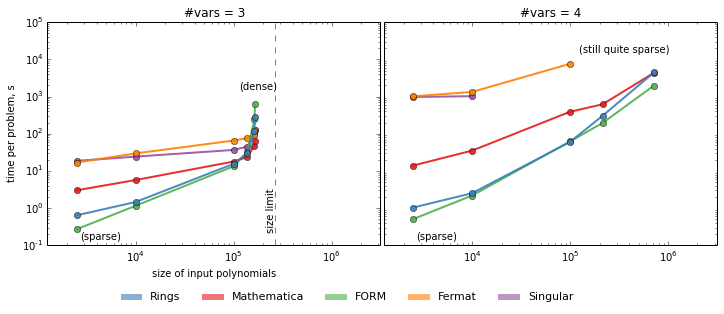

In [13]:
f, (ax3, ax4) = plt.subplots(nrows=1, ncols = 2, figsize=(2*3*2, 2*2))

plot_size_nvars(3, ax = ax3, show_legend=False)
ax3.set_title('#vars = 3')
plot_size_nvars(4, ax = ax4, show_legend=False, show_y_ticks=False, show_x_label=False)
ax4.set_title('#vars = 4')

plt.subplots_adjust(wspace=0.01)

for tool in AllTools:
    ax3.plot([], [], c = style_colors[tool], lw = 6, label = tool, alpha=0.6)
ax3.legend(loc = 'lower center', bbox_to_anchor=(0.9, -0.3), ncol=5, frameon = False, fontsize=11)

plt.savefig('gcd_size.pdf', bbox_inches='tight')

## Performance on dense problems

The following quite dense GCD triplet was used:


\begin{eqnarray}
&& a = (1 + 3 x_1 + 5 x_2 + 7x_3 + 9x_4 + 11x_5 + 13x_6 + 15x_7)^7 - 1 \\
&& b = (1 - 3 x_1 - 5 x_2 - 7x_3 + 9x_4 - 11x_5 - 13x_6 + 15x_7)^7 + 1 \\
&& g = (1 + 3 x_1 + 5 x_2 + 7x_3 + 9x_4 + 11x_5 + 13x_6 - 15x_7)^7 + 3
\end{eqnarray}

Performance of $gcd(ag, bg)$ and $gcd(ag + 1, bg)$ over $Z$ and over $Z_{2^{19}-1}$ was measured.


In [23]:
dense_statistics = pd.read_csv('../denseProblems//results.tsv', sep='\t', header=0)
for tool in AllTools:
    # transform from nanoseconds to seconds
    dense_statistics[tool] = dense_statistics[tool] * 1e-9
dense_statistics    

,Characteristic,Pattern,Rings,Mathematica,FORM,Fermat,Singular
0,0,trivial,0.392943,2.000723,0.258,0.121,0.36
1,0,non-trivial,104.833550,115.285819,148.542,1759.386,141.99
2,524287,trivial,0.550623,2.135326,NaN,0.200,0.24
3,524287,non-trivial,25.525735,33.471950,NaN,147.000,46.34


In [20]:
print(dense_statistics.to_latex(index=False))

\begin{tabular}{rlrrrrr}
\toprule
 Characteristic &      Pattern &       Rings &  Mathematica &     FORM &       Fermat &  Singular \\
\midrule
              0 &      trivial &    0.392943 &     2.000723 &    0.258 &     0.121000 &      0.36 \\
              0 &  non-trivial &  104.833550 &   115.285819 &  148.542 &  1759.386000 &    141.99 \\
         524287 &      trivial &    0.550623 &     2.135326 &      NaN &    28.000000 &      0.24 \\
         524287 &  non-trivial &   25.525735 &    33.471950 &      NaN &  1322.485504 &     46.34 \\
\bottomrule
\end{tabular}

